# **Case Datarisk - Score de Crédito**

## **Importa as bibliotecas e Carrega os Dados**

In [ ]:
from utils.load_df import load_df
from utils.convert_to_datetime import convert_to_datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

import requests
from pathlib import Path

from sklearn.metrics import roc_curve

In [4]:
# Carregar os DataFrames
df_cadastral = load_df("./data/base_cadastral.parquet")
df_emprestimos = load_df("./data/historico_emprestimos.parquet")
df_submissao = load_df("./data/base_submissao.parquet")
df_parcelas = load_df("./data/historico_parcelas.parquet")
dicionario = load_df("./data/dicionario_dados.csv")

## **Converter Datas**

In [5]:
# listar as colunas que precisam de conversão em cada DataFrame
colunas_data_emprestimos = [
    'data_decisao',
    'data_liberacao',
    'data_primeiro_vencimento',
    'data_ultimo_vencimento_original',
    'data_ultimo_vencimento',
    'data_encerramento'
]

colunas_data_parcelas = [
    'data_prevista_pagamento',
    'data_real_pagamento'
]

colunas_data_cadastral = [
    'data_nascimento'
]

df_parcelas = convert_to_datetime(df_parcelas, colunas_data_parcelas)
df_emprestimos = convert_to_datetime(df_emprestimos, colunas_data_emprestimos)
df_cadastral = convert_to_datetime(df_cadastral, colunas_data_cadastral)


--- Verificando tipos de dados ANTES da conversão ---
data_prevista_pagamento    object
data_real_pagamento        object
dtype: object

--- Verificando tipos de dados DEPOIS da conversão ---
data_prevista_pagamento    datetime64[ns]
data_real_pagamento        datetime64[ns]
dtype: object

--- Verificando tipos de dados ANTES da conversão ---
data_decisao                       object
data_liberacao                     object
data_primeiro_vencimento           object
data_ultimo_vencimento_original    object
data_ultimo_vencimento             object
data_encerramento                  object
dtype: object

--- Verificando tipos de dados DEPOIS da conversão ---
data_decisao                       datetime64[ns]
data_liberacao                     datetime64[ns]
data_primeiro_vencimento           datetime64[ns]
data_ultimo_vencimento_original    datetime64[ns]
data_ultimo_vencimento             datetime64[ns]
data_encerramento                  datetime64[ns]
dtype: object

--- Verificando t

## **Explorar Target**


In [6]:
def criar_target_ever_x_mob_y(df_parcelas: pd.DataFrame, dias_atraso: int, mob: int):
    """
    Cria uma variável target binária (0 ou 1) para cada contrato.

    A target será 1 se o cliente alguma vez (EVER) atrasou 'dias_atraso' ou mais
    em qualquer parcela dentro dos primeiros 'mob' meses (Month on Book) do contrato.

    Args:
        df_parcelas (pd.DataFrame): DataFrame com os dados das parcelas.
                                    Deve conter 'id_contrato', 'numero_parcela',
                                    'data_prevista_pagamento' e 'data_real_pagamento'.
        dias_atraso (int): O número de dias de atraso para considerar inadimplência (X).
        mob (int): A janela de observação em meses (Y).

    Returns:
        pd.DataFrame: Um DataFrame com 'id_contrato' e a coluna da nova target.
    """

    df = df_parcelas.copy()

    # Substituir valores nulos em data_real_pagamento pela data atual
    # df['data_real_pagamento'] = df['data_real_pagamento'].fillna(pd.to_datetime('today'))

    # calcula a diferença em dias
    df['dias_atraso'] = (df['data_real_pagamento'] - df['data_prevista_pagamento']).dt.days

    # O 'numero_parcela' é um proxy para o MOB
    df_mob = df[df['numero_parcela'] <= mob].copy()

    # verificar se a condição de inadimplência foi atingida
    df_mob['inadimplente'] = (df_mob['dias_atraso'] >= dias_atraso).astype(int)

    # se o valor máximo de 'inadimplente' para um contrato for 1, ele atingiu a condição.
    target = df_mob.groupby('id_contrato')['inadimplente'].max().reset_index()
    return target

def display_target_proportion(target: pd.DataFrame):
  print(f"Distribuição da target:\n")
  display(target['inadimplente'].value_counts(normalize=True))

In [7]:
target_30_03 = criar_target_ever_x_mob_y(df_parcelas, dias_atraso=30, mob=3)

display_target_proportion(target_30_03)

Distribuição da target:



inadimplente
0    0.996937
1    0.003063
Name: proportion, dtype: float64

In [8]:
df_parcelas_proc = df_parcelas.copy()

# define a data de referência como a última data de vencimento no dataset
data_mais_recente = df_parcelas_proc['data_prevista_pagamento'].max()
print(f"Data de referência (última parcela): {data_mais_recente.strftime('%Y-%m-%d')}")

# o limite de maturação agora é baseado na data mais recente dos dados
data_limite = data_mais_recente - pd.DateOffset(days=90)
df_parcelas_maturado = df_parcelas_proc[df_parcelas_proc['data_prevista_pagamento'] <= data_limite].copy()

# calcular DPD apenas para a base segura, sem usar fillna
df_parcelas_maturado['dias_atraso_calc'] = (df_parcelas_maturado['data_real_pagamento'] - df_parcelas_maturado['data_prevista_pagamento']).dt.days
df_parcelas_maturado.dropna(subset=['dias_atraso_calc'], inplace=True)
df_parcelas_maturado['dias_atraso_calc'] = df_parcelas_maturado['dias_atraso_calc'].clip(lower=0).astype(int)

Data de referência (última parcela): 2025-02-22


In [9]:
# Pega o ID de todos os contratos que *em algum momento* tiveram 180+ dias de atraso
ids_inadimplentes_severos = set(
    df_parcelas_maturado[df_parcelas_maturado['dias_atraso_calc'] >= 60]['id_contrato'].unique()
)
print(f"Encontrados {len(ids_inadimplentes_severos)} contratos com atraso severo.")

Encontrados 1051 contratos com atraso severo.


In [10]:
import itertools

total_contratos = df_emprestimos['id_contrato'].nunique()

mob_list = [x for x in range(3, 25, 3)]
dias_atraso_list = [x for x in range(15, 61, 5)]

# produto cartesiano para gerar todos os cenários
cenarios = list(itertools.product(dias_atraso_list, mob_list))

# calcular a taxa de default para cada cenário
resultados = []
for dias, mob in cenarios:
  target_df = criar_target_ever_x_mob_y(df_parcelas_maturado, dias_atraso=dias, mob=mob)

  inadimplentes_da_target = target_df[target_df['inadimplente'] == 1]

  denominador = len(inadimplentes_da_target)

  if denominador > 0:
      # Numerador: Desses inadimplentes, quantos estão na nossa lista de "prejuízo real"?
      ids_capturados = set(inadimplentes_da_target['id_contrato'])
      numerador = len(ids_capturados.intersection(ids_inadimplentes_severos))

      # Calcular a proporção (taxa de inadimplentes que chegaram a 180 dias de atraso)
      taxa_ever_60 = numerador / denominador
  else:
      taxa_ever_60 = 0 # Evita divisão por zero

  num_inadimplentes = target_df.iloc[:, 1].sum()

  # Calculate taxa_default safely
  taxa_default = target_df['inadimplente'].value_counts(normalize=True)[1]

  resultados.append({'taxa_default': taxa_default, 'mob': mob, 'dias_atraso': dias, 'taxa_ever_60': taxa_ever_60})

# Converter resultados para um DataFrame para facilitar a plotagem
df_resultados = pd.DataFrame(resultados).sort_values('taxa_default', ascending=False)

Vamos comparar as targets.

Com o gráfico abaixo, fica nítido que o ponto de estabilidade está em 12 meses: a partir daí o default aumenta em uma taxa muito menor. Também observa-se a grande diferença entre o ever30 e o ever45, o que indica que muitos clientes que atrasaram 30 dias pagam antes dos 45 dias de atraso. Dessa forma, é interessante escolher um intervalo maior que 45 dias para o atraso, de forma a não penalizar clientes que são bons pagadores. Além disso, a diferença entre ever60 e ever90 é bem menor do que entre o ever45 e o ever60 (apesar de representar o dobro de tempo), assim, não há um ganho significativo em considerar o ever90, tendo em vista que uma grande parte das pessoas que atrasam 60 dias também atrasam 90.

Basenado-se nessa análise, vamos escolher a target como ever60mob12

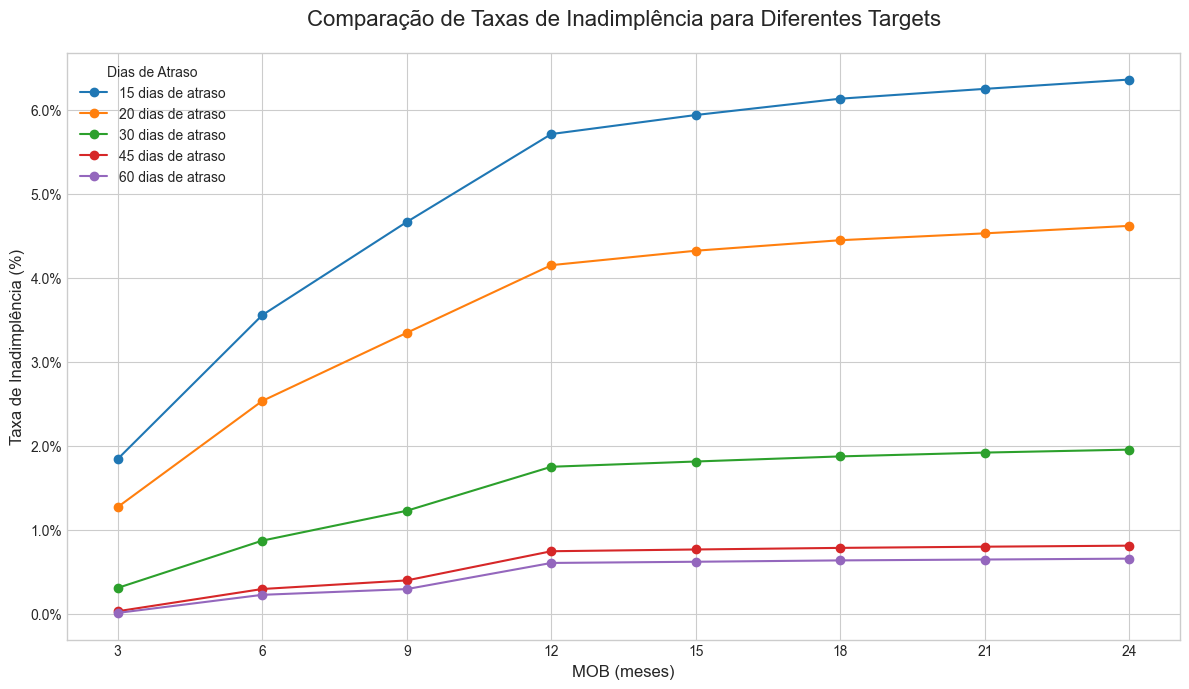

In [11]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Group by dias_atraso and plot lines for each group
for dias in [15, 20, 30, 45, 60]:
    df_subset = df_resultados[df_resultados['dias_atraso'] == dias]
    ax.plot(df_subset['mob'], df_subset['taxa_default'], marker='o', linestyle='-', label=f'{dias} dias de atraso')


# Formatar o eixo Y como porcentagem
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

# Adicionar títulos e labels
ax.set_title('Comparação de Taxas de Inadimplência para Diferentes Targets', fontsize=16, pad=20)
ax.set_xlabel('MOB (meses)', fontsize=12)
ax.set_ylabel('Taxa de Inadimplência (%)', fontsize=12)
plt.xticks(mob_list) # Use the mob_list as ticks
ax.legend(title='Dias de Atraso')
plt.tight_layout()
plt.show()

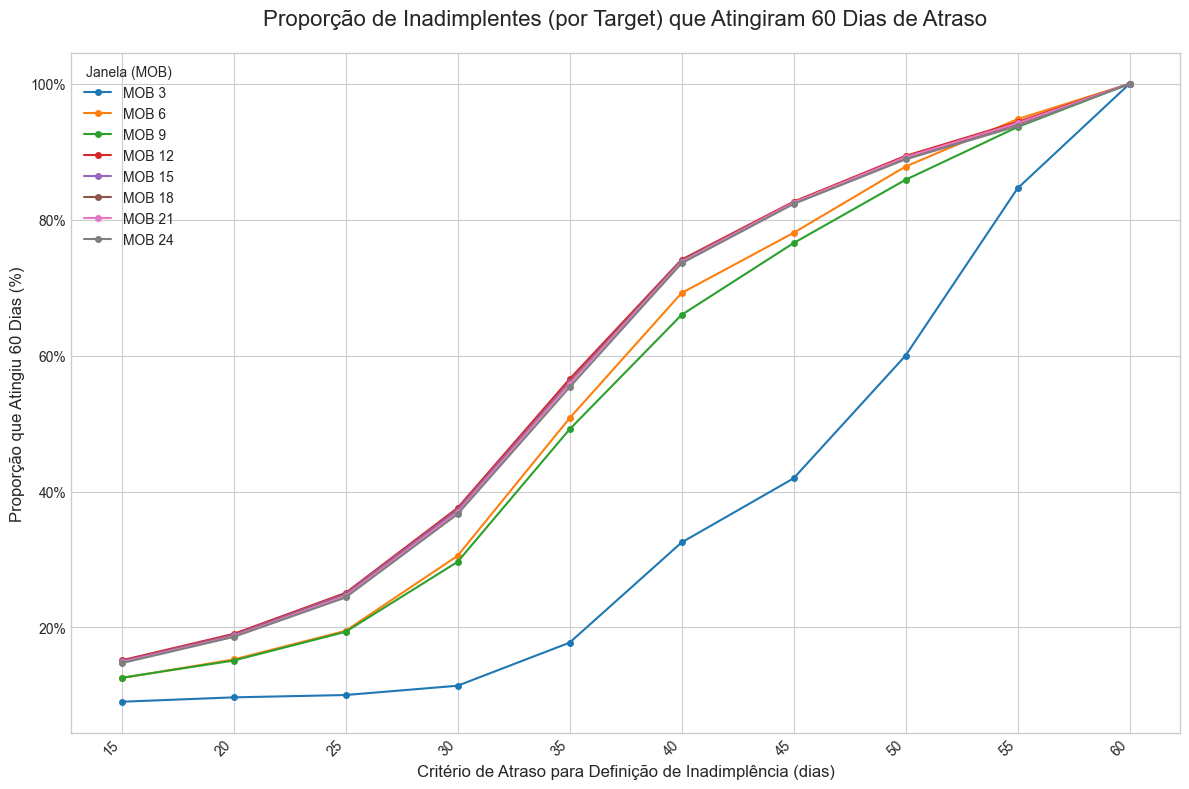

In [12]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

for mob in mob_list:
    df_subset = df_resultados[df_resultados['mob'] == mob].sort_values('dias_atraso')
    ax.plot(df_subset['dias_atraso'], df_subset['taxa_ever_60'], marker='o', markersize=4, linestyle='-', label=f'MOB {mob}')

# Formatar eixos e títulos
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
ax.set_title('Proporção de Inadimplentes (por Target) que Atingiram 60 Dias de Atraso', fontsize=16, pad=20)
ax.set_xlabel('Critério de Atraso para Definição de Inadimplência (dias)', fontsize=12)
ax.set_ylabel('Proporção que Atingiu 60 Dias (%)', fontsize=12)
plt.xticks(dias_atraso_list, rotation=45, ha='right')
ax.legend(title='Janela (MOB)')
plt.tight_layout()
plt.show()

### Salvar DataFrame com as Targets

In [13]:
targets = criar_target_ever_x_mob_y(df_parcelas, dias_atraso=20, mob=12)
targets.to_parquet("./data/targets.parquet", index=False)